In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import gym

In [10]:
def read_data(path):
    results = np.load(path).item()
    
    mean_reward = np.asarray(results['rewards'])[:,0]
    std_reward = np.asarray(results['rewards'])[:,1]
    mean_expert_return = results['expert_returns'][0]
    std_expert_return = results['expert_returns'][1]
    
    return {'mean_reward': mean_reward, 
            'std_reward': std_reward, 
            'mean_expert_return': mean_expert_return, 
            'std_expert_return': std_expert_return,
           }

In [11]:
def plot_returns(data, ax1_ylims=[None,None], ax2_ylims=[None,None], environment=None):
    num_subplots = 1 if ax2_ylims is None else 2
    f, axs = plt.subplots(num_subplots, 1, sharex=True, figsize=(8,5))
    for ax in axs if num_subplots == 2 else [axs]:
        ax.plot(data['mean_reward'], label='our reward')
        ax.fill_between(np.arange(len(data['mean_reward'])), data['mean_reward']-data['std_reward'], data['mean_reward']+data['std_reward'], alpha=0.3)
        if 'mean_expert_return' in data:
            ax.axhline(np.mean(data['mean_expert_return']), color='r', label='expert reward')
            ax.fill_between(np.arange(len(data['mean_reward'])), (data['mean_expert_return']-data['std_expert_return']),(data['mean_expert_return']+data['std_expert_return']), alpha=0.3)
        ax.set_xlim([0,len(data['mean_reward'])-1])
    
    if num_subplots == 2:
        axs[0].set_ylim(ax1_ylims)
        axs[1].set_ylim(ax2_ylims)
        axs[0].spines['bottom'].set_visible(False)
        axs[1].spines['top'].set_visible(False)
        axs[0].xaxis.tick_top()
        axs[0].tick_params(labeltop=False)  # don't put tick labels at the top
        axs[1].xaxis.tick_bottom()

        axs[1].set_xlabel('# Epoch')
        axs[1].legend()
        if not environment is None:
            axs[0].set_title(environment)

        d = .015  # how big to make the diagonal lines in axes coordinates
        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=axs[0].transAxes, color='k', clip_on=False)
        axs[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
        axs[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

        kwargs.update(transform=axs[1].transAxes)  # switch to the bottom axes
        axs[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
        axs[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    else:
        axs.set_xlabel('# Epoch')
        axs.legend()
        if not environment is None:
            axs.set_title(environment)
    
    return f, axs

In [12]:
def load_policy(path, input_dims=1, output_dims=1, num_units=128):
    if len(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='')) > 0:
        tf.reset_default_graph()
        tf.get_default_session().close()
        
    x = tf.placeholder(tf.float32, shape=(None, input_dims))
    hidden1 = tf.layers.dense(x, units=num_units, activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, units=num_units, activation=tf.nn.relu)
    y_pred = tf.layers.dense(hidden2, units=output_dims)
    
    sess = tf.InteractiveSession()
    
    network_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='')
    loaded_params = np.load(path)
    
    sess.run([x.assign(y) for x,y in zip(network_params, loaded_params)])
    
    return x, y_pred, sess

In [13]:
def rollout(env, policy, max_steps=100):
    x, y_pred, sess = policy
    
    obs = env.reset()
    step = 0
    while True:
        action = sess.run(y_pred, feed_dict={x: np.expand_dims(obs, axis=0)})
        obs, reward, done, _ = env.step(action)
        # total_reward += reward
        step += 1

        env.render()

        if done or step >= max_steps:
            break

In [14]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# BC

## (b)

### Reacher

In [7]:
data = read_data('bc_results/Reacher-v2_results.npy')

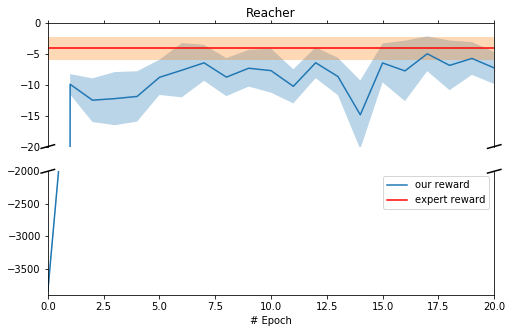

In [8]:
_ = plot_returns(data, ax1_ylims=[-20,0], ax2_ylims=[-3900, -2000], environment='Reacher')

#### Run policy

In [15]:
env = gym.make('Reacher-v2')

In [16]:
epoch = 20 # Between 0 and 20

In [17]:
policy = load_policy(f'bc_results/Reacher-v2_params_ep{epoch:02}.npy', input_dims=env.observation_space.shape[0], output_dims=env.action_space.shape[0])

In [25]:
rollout(env, policy, max_steps=100)

### Hopper

In [26]:
data = read_data('bc_results/Hopper-v2_results.npy')

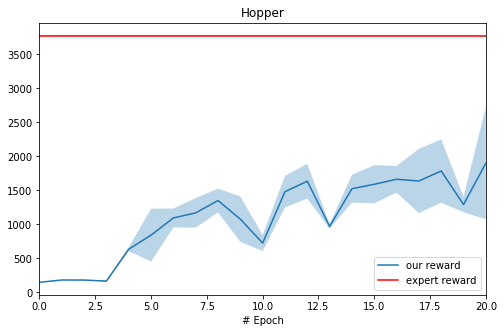

In [27]:
_ = plot_returns(data, ax1_ylims=[3000,4500], ax2_ylims=None, environment='Hopper')

#### Run policy

In [28]:
env = gym.make('Hopper-v2')

In [29]:
epoch = 20 # Between 0 and 20

In [30]:
policy = load_policy(f'bc_results/Hopper-v2_params_ep{epoch:02}.npy', input_dims=env.observation_space.shape[0], output_dims=env.action_space.shape[0])

In [32]:
rollout(env, policy, max_steps=1000)

## (c)

### Number of hidden units

In [33]:
data = {str(x): read_data(f'bc_results/Hopper-v2_nu-{x}_results.npy') for x in [16,32,64,128]}
mean_reward = np.asarray([data[str(x)]['mean_reward'][-1] for x in [16,32,64,128]])
std_reward = np.asarray([data[str(x)]['std_reward'][-1] for x in [16,32,64,128]])

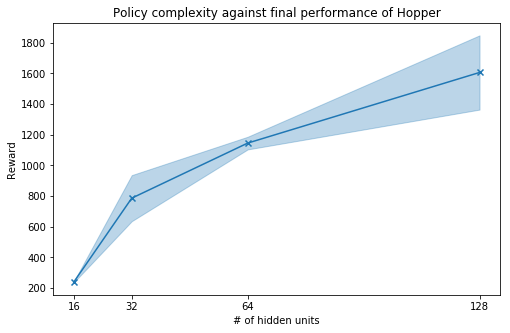

In [34]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.scatter([16,32,64,128], mean_reward, marker='x')
ax.plot([16,32,64,128], mean_reward)
ax.fill_between([16,32,64,128], mean_reward-std_reward, mean_reward+std_reward, alpha=0.3, color=colors[0])
ax.set_xticks([16,32,64,128])
ax.set_xlabel('# of hidden units')
ax.set_ylabel('Reward')
_ = ax.set_title('Policy complexity against final performance of Hopper')

# DAgger

## Hopper

In [35]:
data_bc = read_data('bc_results/Hopper-v2_results.npy')
data_dagger = read_data('dagger_results/Hopper-v2_results.npy')

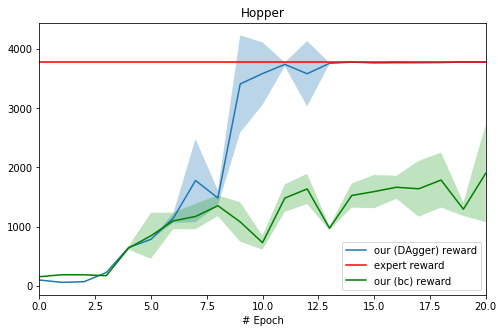

In [36]:
f, axs = plot_returns(data_dagger, ax1_ylims=[3000,4500], ax2_ylims=None, environment='Hopper')
axs.plot(data_bc['mean_reward'], label='our (bc) reward', color='green')
axs.fill_between(np.arange(len(data_bc['mean_reward'])), data_bc['mean_reward']-data_bc['std_reward'], data_bc['mean_reward']+data_bc['std_reward'], alpha=0.3)
L=axs.legend()
L.get_texts()[0].set_text('our (DAgger) reward')

### Run policy

In [37]:
env = gym.make('Hopper-v2')

In [38]:
epoch = 20 # Between 0 and 20

In [39]:
policy = load_policy(f'dagger_results/Hopper-v2_params_ep{epoch:02}.npy', input_dims=env.observation_space.shape[0], output_dims=env.action_space.shape[0])

In [41]:
rollout(env, policy, max_steps=1000)